## Data Preprocessing

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# pip install pyPortfolioOpt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting, CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return

pypfopt.__version__

'1.5.6'

In [267]:
def preprocess_data():
    datafile = "./data/data1.xlsx"
    agg_etf = pd.read_excel(
        datafile, skiprows=4, usecols=[8, 9], names=["Date", "AGG_Returns"]
    )
    agg_etf["AGG_Returns"] = pd.to_numeric(agg_etf["AGG_Returns"], errors="coerce")
    agg_etf["Date"] = pd.to_datetime(agg_etf["Date"], errors="coerce")
    agg_etf = agg_etf.dropna().reset_index(drop=True)

    em_etf = pd.read_excel(
        datafile, skiprows=4, usecols=[0, 1], names=["Date", "MSCI_Returns"]
    )
    em_etf["MSCI_Returns"] = pd.to_numeric(em_etf["MSCI_Returns"], errors="coerce")
    em_etf["Date"] = pd.to_datetime(em_etf["Date"], errors="coerce")
    em_etf = em_etf.dropna().reset_index(drop=True)
    merged_data = pd.merge(agg_etf, em_etf, on="Date", how="inner")
    merged_data.set_index('Date', inplace = True)
    merged_data.sort_index(inplace = True)

    return merged_data

In [268]:
df = preprocess_data()
df[['AGG_Returns', 'MSCI_Returns']] = df[['AGG_Returns', 'MSCI_Returns']]/100
df.head(3)

,AGG_Returns,MSCI_Returns
Date,,
2003-10-31,-0.0096,0.0874
2003-11-30,0.0022,0.0167
2003-12-31,0.0103,0.0799


In [269]:
# train test split on 2020
train_df = df[df.index < '2020-01-01']
test_df = df[df.index >= '2020-01-01']

In [270]:
# # check mu manually
# # Ensure train_df is a copy of the original DataFrame slice
# train_df = train_df.copy()

# # Extract the year and assign it to a new column
# train_df.loc[:, 'Year'] = train_df.index.year

# nasdaq_yearly_returns = train_df.groupby('Year')['NASDAQ_Returns'].apply(lambda x: (x + 1).prod() - 1)
# msci_yearly_returns = train_df.groupby('Year')['MSCI_Returns'].apply(lambda x: (x + 1).prod() - 1)

# # Calculate the mean historical yearly return for each
# mean_yearly_return_nasdaq = nasdaq_yearly_returns.mean()
# mean_yearly_return_msci = msci_yearly_returns.mean()

# # Display results
# print("NASDAQ Yearly Returns:")
# print(nasdaq_yearly_returns)
# print("\nMSCI Yearly Returns:")
# print(msci_yearly_returns)
# print(f"\nMean Historical Yearly Return (NASDAQ): {mean_yearly_return_nasdaq:.4f}")
# print(f"Mean Historical Yearly Return (MSCI): {mean_yearly_return_msci:.4f}")

In [271]:
mu = mean_historical_return(train_df, returns_data = True, frequency = 12)
S = risk_models.CovarianceShrinkage(train_df, returns_data = True, frequency = 12).ledoit_wolf()

In [272]:
mu, S

(AGG_Returns     0.039680
 MSCI_Returns    0.089246
 dtype: float64,
               AGG_Returns  MSCI_Returns
 AGG_Returns      0.001881      0.000691
 MSCI_Returns     0.000691      0.042695)

## Min-Variance Model

In [273]:
sample_cov = risk_models.sample_cov(train_df, returns_data=True, frequency=12)
sample_cov

,AGG_Returns,MSCI_Returns
AGG_Returns,0.001060,0.000723
MSCI_Returns,0.000723,0.043747


<Axes: >

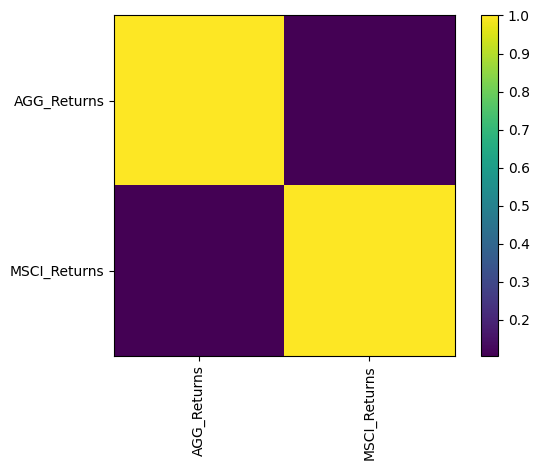

In [274]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

In [275]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

ef.min_volatility()
MV_weight_train = ef.clean_weights()
MV_weight_train

OrderedDict([('AGG_Returns', 0.97246), ('MSCI_Returns', 0.02754)])

<Axes: >

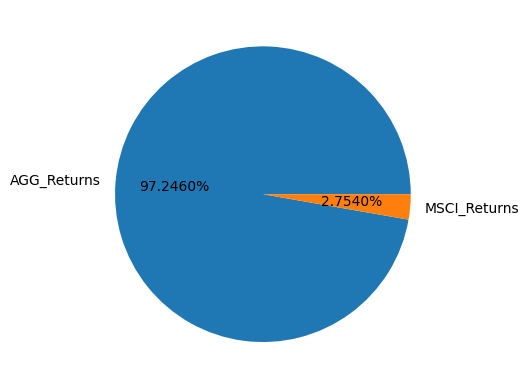

In [276]:
pd.Series(MV_weight_train).plot.pie(autopct='%1.4f%%')

In [277]:
ef.portfolio_performance(verbose= True)

Expected annual return: 4.1%
Annual volatility: 4.3%
Sharpe Ratio: 0.95


(0.04104537667974904, 0.04299281513230722, 0.9547031650157107)

## Max Sharpe Ratio Model

In [278]:
ef_sharpe = EfficientFrontier(mu, S, weight_bounds=(-1,1))
ef_sharpe.max_sharpe()
MS_weight_train = ef_sharpe.clean_weights()
MS_weight_train

OrderedDict([('AGG_Returns', 0.92078), ('MSCI_Returns', 0.07922)])

In [279]:
ef_sharpe.portfolio_performance(verbose=True)

Expected annual return: 4.4%
Annual volatility: 4.4%
Sharpe Ratio: 0.98


(0.04360674709109677, 0.04431396455607918, 0.9840407539233501)

<Axes: >

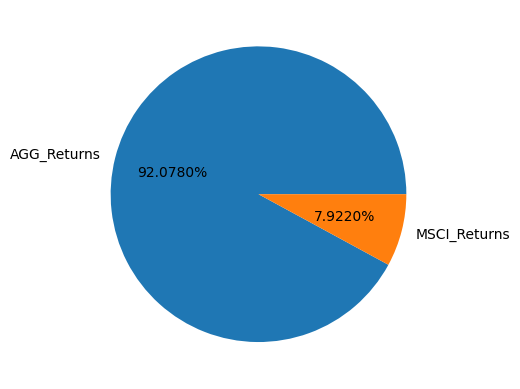

In [280]:
pd.Series(MS_weight_train).plot.pie(autopct='%1.4f%%')

## Plotting

use the critical line algorithm.

In [303]:
# Min Var
cla = CLA(mu, S)
cla.min_volatility()
cla.portfolio_performance(verbose=True)

Expected annual return: 4.1%
Annual volatility: 4.3%
Sharpe Ratio: 0.95


(0.04104537667974906, 0.042992815132307224, 0.954703165015711)

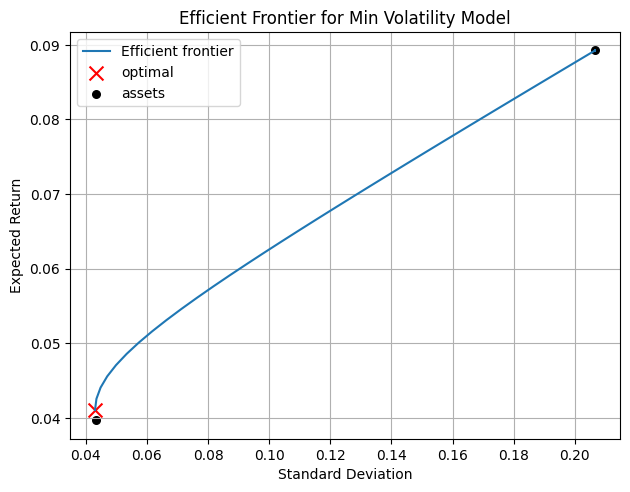

In [304]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)
plt.title('Efficient Frontier for Min Volatility Model')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.legend()
plt.grid()
plt.show()

In [283]:
# Max Sharpe
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose = True)

Expected annual return: 4.4%
Annual volatility: 4.4%
Sharpe Ratio: 0.98


(0.04360674694519706, 0.04431396440781325, 0.9840407539233502)

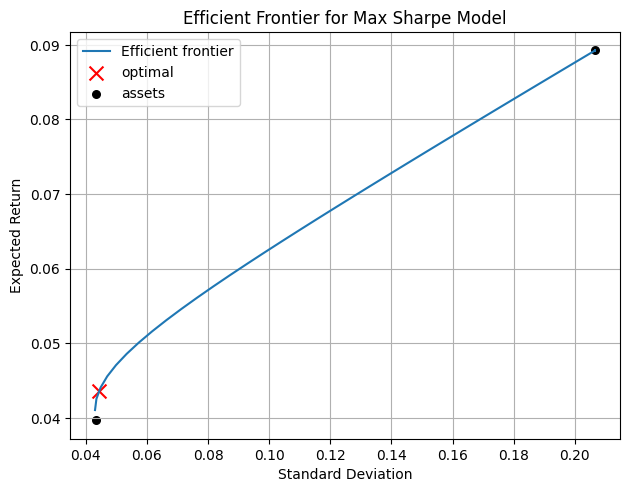

In [302]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)
plt.title('Efficient Frontier for Max Sharpe Model')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# just for fun

ax = plotting.plot_efficient_frontier(cla, showfig=False, interactive=True)
ax.show()

# Test Data Performance

In [286]:
# # Min-Variance Model
# mu = mean_historical_return(test_df, returns_data = True, frequency = 12)
# S = risk_models.CovarianceShrinkage(test_df, returns_data = True, frequency = 12).ledoit_wolf()
# ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
# ef.min_volatility()
# MV_weight_test = ef.clean_weights()
# print(MV_weight_test)
# ef.portfolio_performance(verbose=True)


In [287]:
# # Max-Sharpe
# ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
# ef.max_sharpe()
# MS_weight_test = ef.clean_weights()
# print(MS_weight_test)
# ef.portfolio_performance(verbose=True)

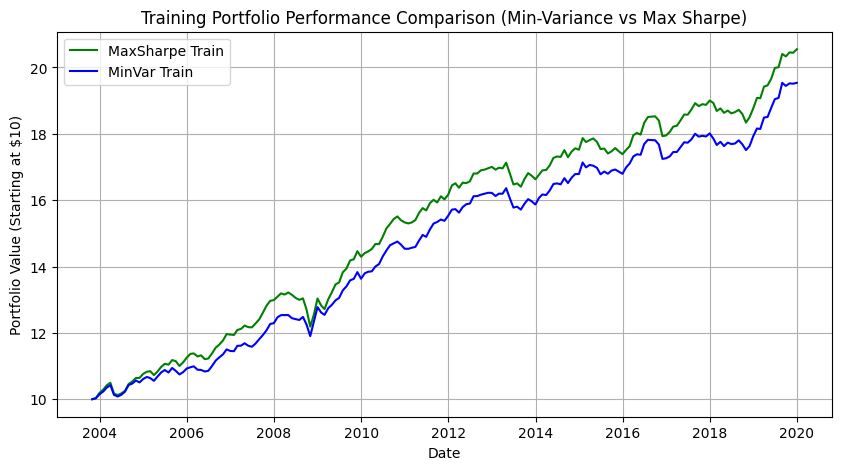

In [288]:
# Train

# Define the weights for both models in test datasets
min_var_train_weights = {'AGG_Weights': MV_weight_train['AGG_Returns'], 'MSCI_Weights': MV_weight_train['MSCI_Returns']}
max_sharpe_train_weights = {'AGG_Weights': MS_weight_train['AGG_Returns'], 'MSCI_Weights': MS_weight_train['MSCI_Returns']}


# Initial investment
initial_investment = 10

# Function to compute portfolio value using returns
def compute_portfolio_value_with_returns(df, weights, initial_investment):
    # Calculate weighted portfolio returns
    portfolio_returns = (
        df['AGG_Returns'] * weights['AGG_Weights'] +
        df['MSCI_Returns'] * weights['MSCI_Weights']
    )
    # Compute cumulative portfolio value
    cumulative_returns = (1 + portfolio_returns).cumprod()
    portfolio_value = cumulative_returns / cumulative_returns.iloc[0] * initial_investment
    return portfolio_value


# Calculate portfolio performance for test data
train_df_returns = train_df.copy()  # Ensure a copy of the test DataFrame


train_df_returns['MinVar_Train'] = compute_portfolio_value_with_returns(
    train_df_returns, min_var_train_weights, initial_investment)

train_df_returns['MaxSharpe_Train'] = compute_portfolio_value_with_returns(
    train_df_returns, max_sharpe_train_weights, initial_investment)


# Plot the portfolio performance
plt.figure(figsize=(10, 5))

# Training performance
plt.plot(train_df_returns.index, train_df_returns['MaxSharpe_Train'], label='MaxSharpe Train', color='green')
plt.plot(train_df_returns.index, train_df_returns['MinVar_Train'], label='MinVar Train', color='blue')



# Add labels, title, and legend
plt.title('Training Portfolio Performance Comparison (Min-Variance vs Max Sharpe)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Starting at $10)')
plt.legend()
plt.grid()
plt.show()

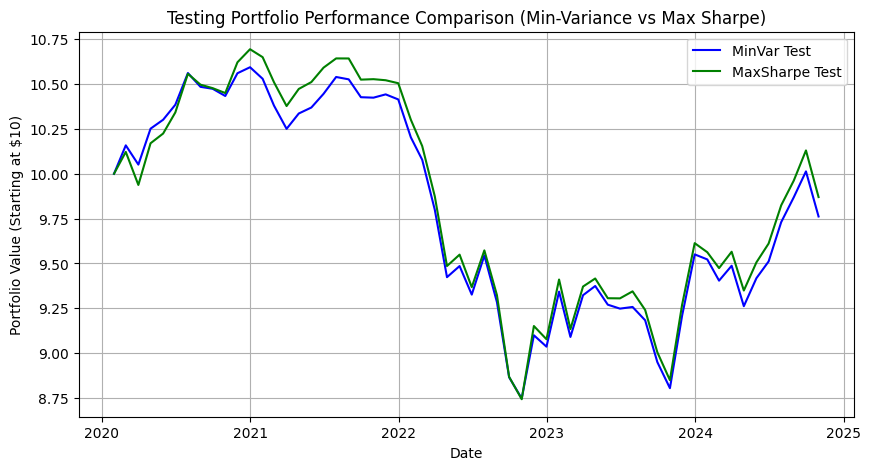

In [289]:
# test


# min_var_test_weights = {'NASDAQ_Weights': MV_weight_test['NASDAQ_Returns'], 'MSCI_Weights': MV_weight_test['MSCI_Returns']}
# max_sharpe_test_weights = {'NASDAQ_Weights': MS_weight_test['NASDAQ_Returns'], 'MSCI_Weights': MS_weight_test['MSCI_Returns']}



# Calculate portfolio performance for test data
test_df_returns = test_df.copy()  # Ensure a copy of the test DataFrame


test_df_returns['MinVar_Test'] = compute_portfolio_value_with_returns(
    test_df_returns, min_var_train_weights, initial_investment)

test_df_returns['MaxSharpe_Test'] = compute_portfolio_value_with_returns(
    test_df_returns, max_sharpe_train_weights, initial_investment)

# Plot the portfolio performance
plt.figure(figsize=(10, 5))

# Testing performance
plt.plot(test_df_returns.index, test_df_returns['MinVar_Test'], label='MinVar Test', color='blue')
plt.plot(test_df_returns.index, test_df_returns['MaxSharpe_Test'], label='MaxSharpe Test', color='green')


# Add labels, title, and legend
plt.title('Testing Portfolio Performance Comparison (Min-Variance vs Max Sharpe)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Starting at $10)')
plt.legend()
plt.grid()
plt.show()

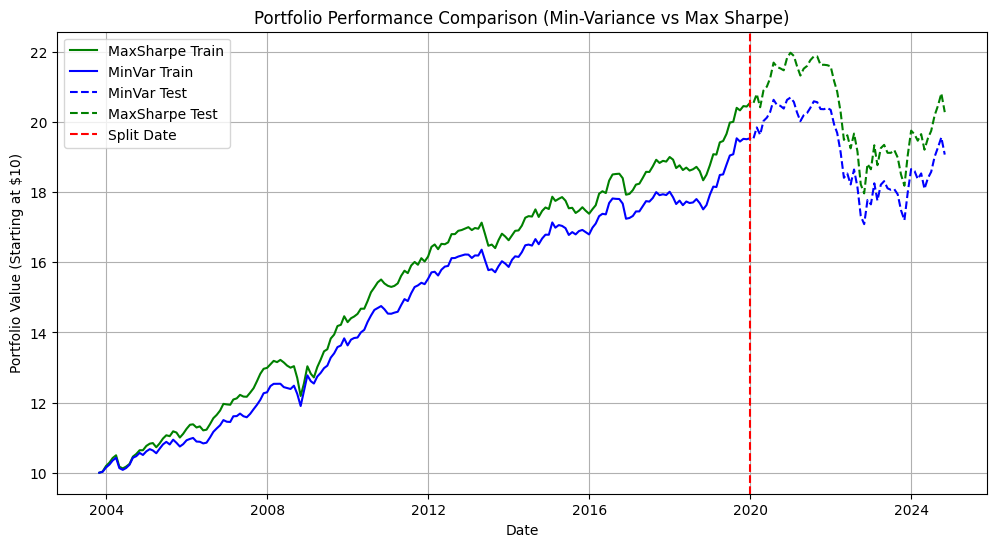

In [290]:
# combine all

train_df_returns = train_df.copy()  # Ensure a copy of the test DataFrame
test_df_returns = test_df.copy()  # Ensure a copy of the test DataFrame

train_df_returns['MinVar_Train'] = compute_portfolio_value_with_returns(
    train_df_returns, min_var_train_weights, initial_investment)

train_df_returns['MaxSharpe_Train'] = compute_portfolio_value_with_returns(
    train_df_returns, max_sharpe_train_weights, initial_investment)

test_df_returns['MinVar_Test'] = compute_portfolio_value_with_returns(
    test_df_returns, min_var_train_weights, train_df_returns['MinVar_Train'].iloc[-1])

test_df_returns['MaxSharpe_Test'] = compute_portfolio_value_with_returns(
    test_df_returns, max_sharpe_train_weights, train_df_returns['MaxSharpe_Train'].iloc[-1])

# Plot the portfolio performance
plt.figure(figsize=(12, 6))

# Training performance
plt.plot(train_df_returns.index, train_df_returns['MaxSharpe_Train'], label='MaxSharpe Train', color='green')
plt.plot(train_df_returns.index, train_df_returns['MinVar_Train'], label='MinVar Train', color='blue')

# Testing performance
plt.plot(test_df_returns.index, test_df_returns['MinVar_Test'], label='MinVar Test', color='blue', linestyle='dashed')
plt.plot(test_df_returns.index, test_df_returns['MaxSharpe_Test'], label='MaxSharpe Test', color='green', linestyle='dashed')

# Add a vertical line for the split date
plt.axvline(pd.to_datetime('2020-01-01'), color='red', linestyle='--', label='Split Date')

# Add labels, title, and legend
plt.title('Portfolio Performance Comparison (Min-Variance vs Max Sharpe)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Starting at $10)')
plt.legend()
plt.grid()
plt.show()

# Comparing Overall Performance

## Importing Weights

In [291]:
def import_train_weights(filename):
    filepath = os.path.join("./model_weights_train/", filename) 
    df = pd.read_csv(filepath)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df['AGG_Weights'] = df['AGG']
    df.drop(columns=['AGG'], inplace=True)
    df['MSCI_Weights'] = df['MSCI']
    df.drop(columns=['MSCI'], inplace=True)
    df.dropna().reset_index(drop=True) 
    df.set_index('Date', inplace = True)
    
    return df

def import_test_weights(filename):
    filepath = os.path.join("./model_weights_test/", filename) 
    df = pd.read_csv(filepath)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df['AGG_Weights'] = df['AGG']
    df.drop(columns=['AGG'], inplace=True)
    df['MSCI_Weights'] = df['MSCI']
    df.drop(columns=['MSCI'], inplace=True)
    df.dropna().reset_index(drop=True)
    df.set_index('Date', inplace = True)
    
    return df

In [292]:
# train

filenames = [
    "train_gradientTD_dsr.csv",
    "train_gradientTD.csv",
    "train_q_learning_dsr.csv",
    "train_q_learning.csv",
    "train_sarsa_dsr.csv",
    "train_sarsa.csv"
]

dataframes_train = {}

for file in filenames:
    dataframes_train[file.split('.')[0]] = import_train_weights(file)

dataframes_train['train_gradientTD']

,AGG_Weights,MSCI_Weights
Date,,
2003-11-30,0.343233,0.656767
2003-12-31,0.343233,0.656767
2004-01-31,0.343233,0.656767
2004-02-29,0.343233,0.656767
2004-03-31,0.343233,0.656767
...,...,...
2019-08-31,0.343233,0.656767
2019-09-30,0.343233,0.656767
2019-10-31,0.343233,0.656767


In [293]:
# test

filenames = [
    "gradientTD_dsr.csv",
    "gradientTD.csv",
    "q_learning_dsr.csv",
    "q_learning.csv",
    "sarsa_dsr.csv",
    "sarsa.csv"
]

dataframes = {}

for file in filenames:
    dataframes[file.split('.')[0]] = import_test_weights(file)

## Train

In [294]:
train_df_returns = train_df.copy() 
train_df_returns = train_df_returns.iloc[1:] # remove first row for alignment

train_df_returns['MinVar'] = compute_portfolio_value_with_returns(
    train_df_returns, min_var_train_weights, initial_investment)
train_df_returns['MaxSharpe'] = compute_portfolio_value_with_returns(
    train_df_returns, max_sharpe_train_weights, initial_investment)

for name, df in dataframes_train.items():
    train_df_returns[name] = compute_portfolio_value_with_returns(
        train_df_returns, df, initial_investment)
    
train_df_returns.head(3)

,AGG_Returns,MSCI_Returns,MinVar,MaxSharpe,train_gradientTD_dsr,train_gradientTD,train_q_learning_dsr,train_q_learning,train_sarsa_dsr,train_sarsa
Date,,,,,,,,,,
2003-11-30,0.0022,0.0167,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.00000
2003-12-31,0.0103,0.0799,10.122168,10.158137,10.107869,10.560110,10.103000,10.79900,10.103000,10.79900
2004-01-31,0.0077,0.0297,10.206241,10.254059,10.187256,10.794004,10.180793,11.11973,10.180793,11.11973


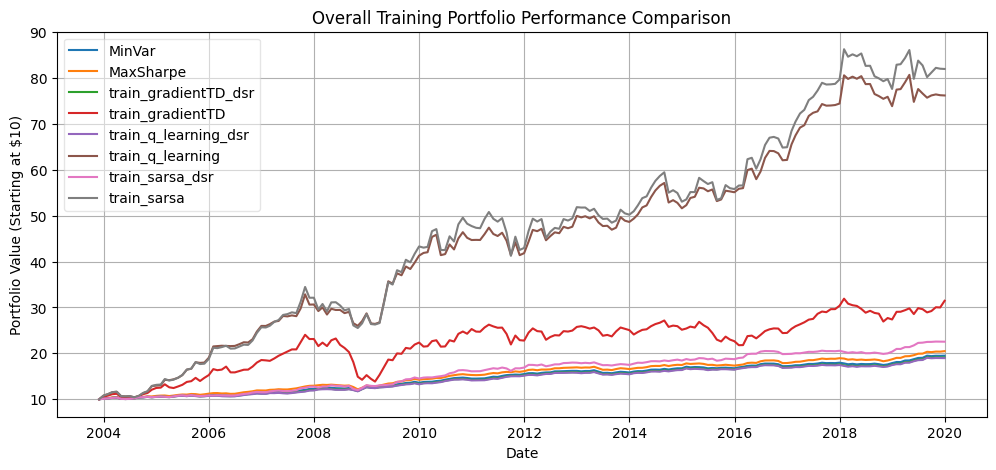

In [295]:
# plot
plt.figure(figsize=(12, 5))

for col in train_df_returns.iloc[:, 2:]:
    plt.plot(train_df_returns.index, train_df_returns[col], label=col)


plt.title('Overall Training Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Starting at $10)')
plt.legend()
plt.grid()
plt.legend(framealpha=0.5)
plt.show()

## Test

In [296]:
test_df_returns = test_df.copy()  

test_df_returns['MinVar'] = compute_portfolio_value_with_returns(
    test_df_returns, min_var_train_weights, initial_investment)
test_df_returns['MaxSharpe'] = compute_portfolio_value_with_returns(
    test_df_returns, max_sharpe_train_weights, initial_investment)
# add rl models
for name, df in dataframes.items():
    test_df_returns[name] = compute_portfolio_value_with_returns(
        test_df_returns, df, initial_investment)
    
test_df_returns.head(3)

,AGG_Returns,MSCI_Returns,MinVar,MaxSharpe,gradientTD_dsr,gradientTD,q_learning_dsr,q_learning,sarsa_dsr,sarsa
Date,,,,,,,,,,
2020-01-31,0.0191,-0.0473,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
2020-02-29,0.0178,-0.0530,10.158502,10.121912,10.173047,9.713009,10.178000,9.824000,10.178000,9.470000
2020-03-31,-0.0065,-0.1542,10.051150,9.937685,10.096410,8.707669,10.111843,9.034642,10.111843,8.009726


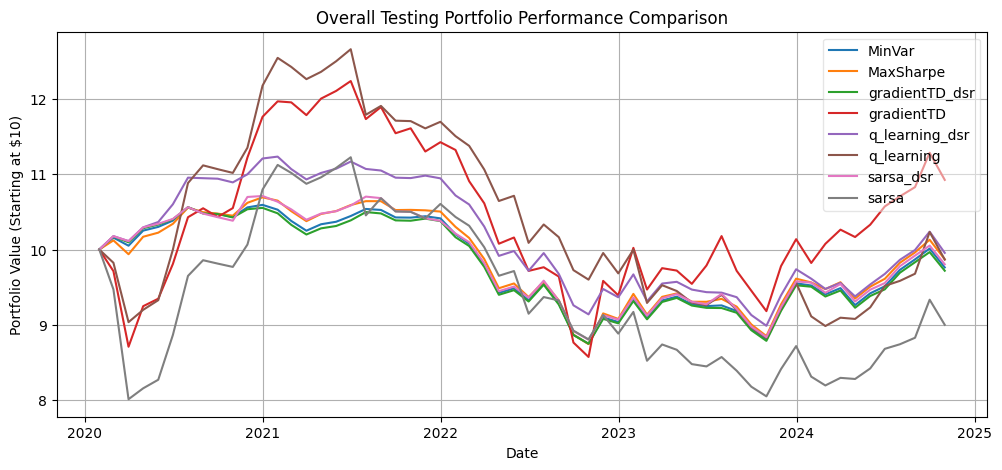

In [297]:
# plot
plt.figure(figsize=(12, 5))

for col in test_df_returns.iloc[:, 2:]:
    plt.plot(test_df_returns.index, test_df_returns[col], label=col)


plt.title('Overall Testing Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Starting at $10)')
plt.legend()
plt.grid()
plt.legend(framealpha=0.5)
plt.show()

## All

In [298]:
train_df_returns.head(3)

,AGG_Returns,MSCI_Returns,MinVar,MaxSharpe,train_gradientTD_dsr,train_gradientTD,train_q_learning_dsr,train_q_learning,train_sarsa_dsr,train_sarsa
Date,,,,,,,,,,
2003-11-30,0.0022,0.0167,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.00000
2003-12-31,0.0103,0.0799,10.122168,10.158137,10.107869,10.560110,10.103000,10.79900,10.103000,10.79900
2004-01-31,0.0077,0.0297,10.206241,10.254059,10.187256,10.794004,10.180793,11.11973,10.180793,11.11973


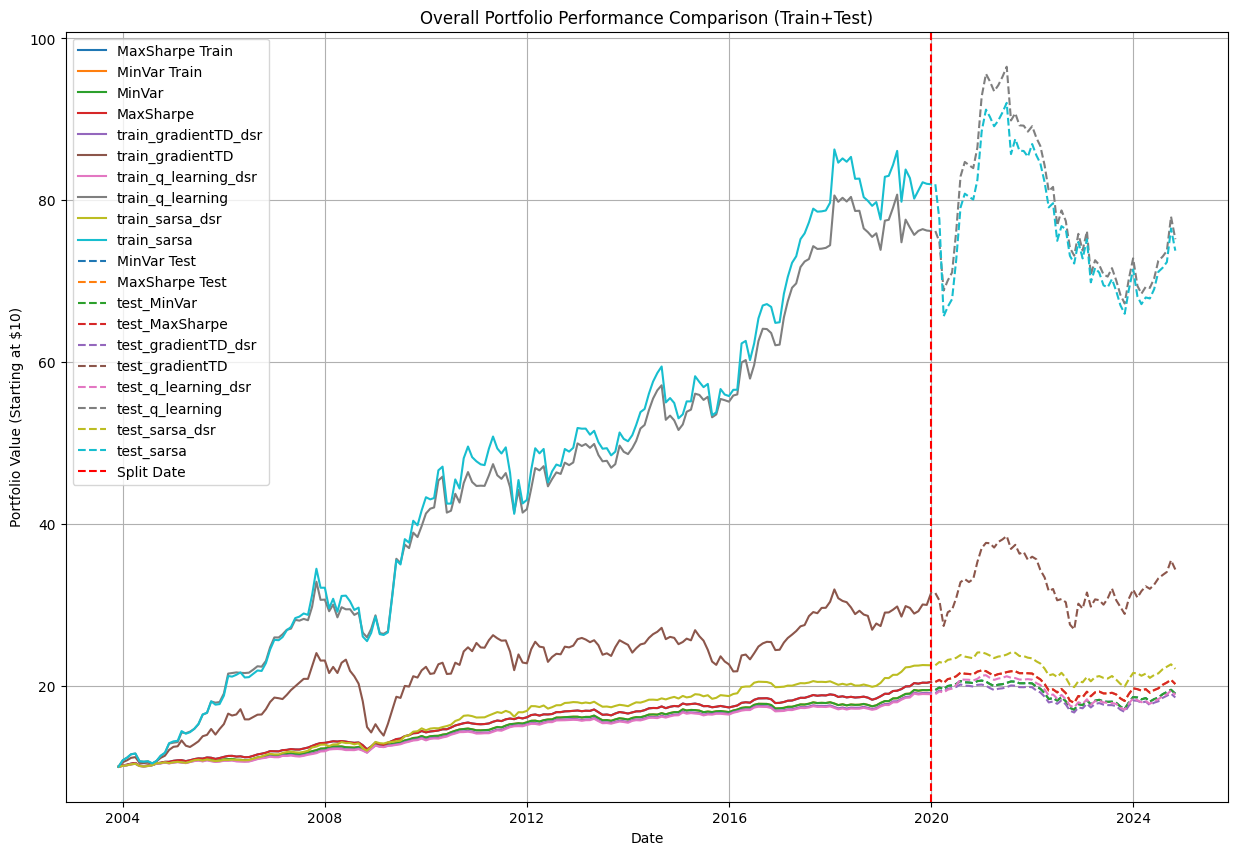

In [299]:
test_df_returns = test_df.copy()

# recalculate last points
test_df_returns['test_MinVar'] = compute_portfolio_value_with_returns(
    test_df_returns, min_var_train_weights, train_df_returns['MinVar'].iloc[-1])

test_df_returns['test_MaxSharpe'] = compute_portfolio_value_with_returns(
    test_df_returns, max_sharpe_train_weights, train_df_returns['MaxSharpe'].iloc[-1])

# add rl models
for name, df in dataframes.items():
    test_df_returns['test_' + name] = compute_portfolio_value_with_returns(
        test_df_returns, df, train_df_returns['train_' + name].iloc[-1])


# Plot the portfolio performance
plt.figure(figsize=(15, 10))

# Training performance
plt.plot(train_df_returns.index, train_df_returns['MaxSharpe'], label='MaxSharpe Train')
plt.plot(train_df_returns.index, train_df_returns['MinVar'], label='MinVar Train')
for col in train_df_returns.iloc[:, 2:]:
    plt.plot(train_df_returns.index, train_df_returns[col], label=col)



# Testing performance
plt.plot(test_df_returns.index, test_df_returns['test_MinVar'], label='MinVar Test', linestyle='dashed')
plt.plot(test_df_returns.index, test_df_returns['test_MaxSharpe'], label='MaxSharpe Test', linestyle='dashed')
for col in test_df_returns.iloc[:, 2:]:
    plt.plot(test_df_returns.index, test_df_returns[col], label=col, linestyle='dashed')



# Add a vertical line for the split date
plt.axvline(pd.to_datetime('2020-01-01'), color='red', linestyle='--', label='Split Date')

# Add labels, title, and legend
plt.title('Overall Portfolio Performance Comparison (Train+Test)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Starting at $10)')
plt.legend()
plt.grid()
plt.show()